In [102]:
import torch
import torchvision

from torch import nn
from torchsummary import summary   #used for finding summary
from torch.utils.data import DataLoader  
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.utils import save_image

import time
from progressbar import *
import os
import matplotlib.pyplot as plt 
import numpy as np

In [103]:
#Enable cuda if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, "is available ")

cuda is available 


## Image transformation
* `Normalising images `
* **GPU/CPU** enabled using .to(device) 
* Converting to tensor

In [122]:
#image for transformation 
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

### Loading and testing dataloader

* use numpy traspose(1,2,0) to get the data back to orignal dimentions as the dataset output in terms of
`batch, channel, height, widht`

In [123]:
train_dataset = datasets.ImageFolder(root='./dog_data', transform=img_transform)
trainset = DataLoader(dataset = train_dataset,
                     batch_size=batch_size,
                     shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


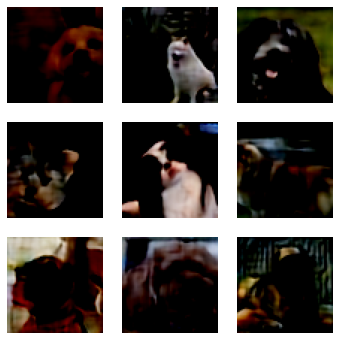

In [124]:
data, _ = next(iter(trainset))
fig = plt.figure(figsize=(12, 6))
for row in range(1, 4):  # show 3 rows
    for col in range(1, 4):  # show 3 columns
        index = 6 * (row - 1) + col
        image = data[index - 1, :] # retrieve images as (28, 28) tensors
        fig.add_subplot(3, 6, index)
        plt.imshow(image.numpy().transpose(1,2,0))

        plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])


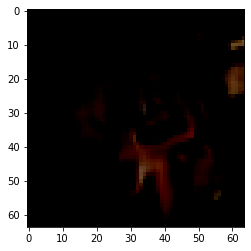

In [125]:
from torch.autograd import Variable
print(data.shape)
output = data[3,:].cpu().detach().numpy().transpose(1,2,0)
plt.imshow(output)
# plt.imshow(data[1,:].reshape(64,64,3))

## Model

In [131]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 128, 4,stride=1, padding = 2),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
                nn.ReLU(),
                nn.ConvTranspose2d(64,3,4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

summary(model, (3,64,64))   #used for finding summary 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 66, 66]             896
              ReLU-2           [-1, 32, 66, 66]               0
         MaxPool2d-3           [-1, 32, 33, 33]               0
            Conv2d-4           [-1, 64, 35, 35]          18,496
              ReLU-5           [-1, 64, 35, 35]               0
         MaxPool2d-6           [-1, 64, 17, 17]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         131,200
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]         131,136
             ReLU-10           [-1, 64, 32, 32]               0
  ConvTranspose2d-11            [-1, 3, 64, 64]           3,075
Total params: 284,803
Trainable params: 284,803
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/

## Training Model

In [132]:
for epochs in range(num_epochs):
    for i, (images, labels) in enumerate(trainset):
        img = Variable(images).to(device)
        output = model.forward(img)
        optimizer.zero_grad()
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        if (i) % 30 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epochs+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data.item()))

Epoch [1/10], Iter [1/78] Loss: 0.1951
Epoch [1/10], Iter [31/78] Loss: 0.0357
Epoch [1/10], Iter [61/78] Loss: 0.0179
Epoch [2/10], Iter [1/78] Loss: 0.0152
Epoch [2/10], Iter [31/78] Loss: 0.0114
Epoch [2/10], Iter [61/78] Loss: 0.0099
Epoch [3/10], Iter [1/78] Loss: 0.0090
Epoch [3/10], Iter [31/78] Loss: 0.0082
Epoch [3/10], Iter [61/78] Loss: 0.0072
Epoch [4/10], Iter [1/78] Loss: 0.0065
Epoch [4/10], Iter [31/78] Loss: 0.0061
Epoch [4/10], Iter [61/78] Loss: 0.0059
Epoch [5/10], Iter [1/78] Loss: 0.0058
Epoch [5/10], Iter [31/78] Loss: 0.0054
Epoch [5/10], Iter [61/78] Loss: 0.0056
Epoch [6/10], Iter [1/78] Loss: 0.0048
Epoch [6/10], Iter [31/78] Loss: 0.0045
Epoch [6/10], Iter [61/78] Loss: 0.0044
Epoch [7/10], Iter [1/78] Loss: 0.0040
Epoch [7/10], Iter [31/78] Loss: 0.0041
Epoch [7/10], Iter [61/78] Loss: 0.0041
Epoch [8/10], Iter [1/78] Loss: 0.0043
Epoch [8/10], Iter [31/78] Loss: 0.0038
Epoch [8/10], Iter [61/78] Loss: 0.0039
Epoch [9/10], Iter [1/78] Loss: 0.0038
Epoch [9/

## Validation set --> Testing if we get any results 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


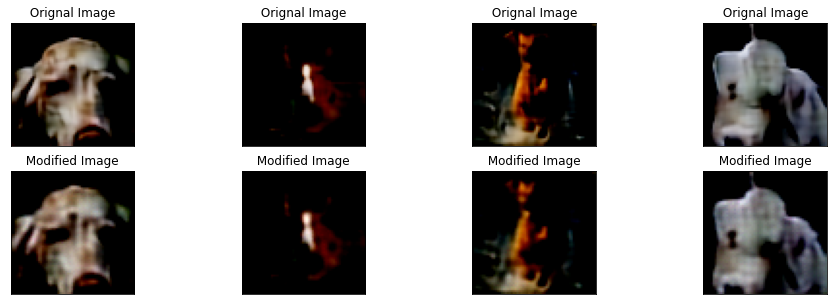

In [140]:
model.eval()

# total images to display
n = 5
plt.figure(figsize=(20,n))

for images, labels in trainset:
    
    images = Variable(images).to(device)
    outputs = model.forward(images)
    count = 0
    
    in_out = zip(images, outputs)
    for image, output in in_out:
        count += 1
        if count >= n:
            break
            
        # display original images    
        ax = plt.subplot(2, n, count + 1)
        #print output.shape
        plt.imshow(image.data.cpu().detach().numpy().transpose(1,2,0))
        plt.title(" Orignal Image ")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, n, count + 1 + n)
        #print output.shape
        plt.imshow(output.data.cpu().detach().numpy().transpose(1,2,0))
        plt.title(" Modified Image ")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)   
            
    break